## 配置环境和导入数据，并可视化检查数据集
使用CIFAR-10 数据集
batch size 为64
设置随机种子

In [1]:
# 1. 导入必要的库和自己定义的模块
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
# 从自己定义的模块中导入函数

import sys
sys.path.append('..') # 将父目录添加到Python路径，以便导入 models 和 utils
from utils.data_utils import get_cifar10_dataloaders
from models.simple_cnn import SimpleCNN
# 导入设置随机种子的函数
from utils.train_eval_utils import set_seed

# 设置随机种子
SEED = 66 
set_seed(SEED)

# 导入新的训练和评估工具函数
from utils.train_eval_utils import train_model, evaluate_model, save_model, load_model

# 2. 设备设置
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for training.")
else:
    device = torch.device("cpu")
    print("MPS device not available, using CPU for training.")


Random seed set to 66
Using MPS device for training.


## 导入迁移学习的模块（可选）

In [2]:
# 导入为迁移学习准备的数据加载函数
from utils.data_utils import get_cifar10_dataloaders_for_transfer_learning
# 导入迁移学习模型
from models.resnet_transfer_model import ResNetTransferModel

## simple_cnn模型的数据加载与预览

In [ ]:
# 3. 数据加载
batch_size = 64
data_root = '../data' # 数据集将下载到项目根目录下的 data 文件夹
train_loader, test_loader, classes = get_cifar10_dataloaders(batch_size=batch_size, data_root=data_root)

print(f"\nTraining data loaded: {len(train_loader.dataset)} samples, {len(train_loader)} batches.")
print(f"Test data loaded: {len(test_loader.dataset)} samples, {len(test_loader)} batches.")
print(f"Number of classes: {len(classes)}")

# 可视化一些数据
def imshow(img):
    # CIFAR-10 的 Normalize 参数
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2471, 0.2435, 0.2616])
    img = img.numpy().transpose((1, 2, 0)) # 将(C, H, W)变为(H, W, C)
    img = std * img + mean # 反标准化
    img = np.clip(img, 0, 1) # 将像素值裁剪到[0,1]
    plt.imshow(img)
    plt.show()

# 获取一个随机批次并显示
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
imshow(torchvision.utils.make_grid(images[:4]))

## 实例化定义好的simple_cnn模型，选择合适的Loss函数和optimization
Loss使用交叉熵
优化器选择Adam，初始学习率设定为0.001
模型结构为[卷积层 -> 激活函数 -> 池化层] x 3 次 + 展平 -> [全连接层 -> 激活函数] x 3 次

In [ ]:
# 4. 实例化模型、定义损失函数和优化器

model = SimpleCNN().to(device) # 实例化模型并移动到指定设备
print("\nSimple CNN Model Structure:")
print(model)

criterion = nn.CrossEntropyLoss() # 损失函数
initial_learning_rate = 0.001 # 初始学习率

# 定义优化器，并添加 weight_decay 参数
# weight_decay 是一个超参数，常用的值是 1e-4, 5e-4, 1e-3 等
# 我们从一个常用值开始尝试
weight_decay_value = 1e-5 # 这是一个常用的起始值
optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate, weight_decay=weight_decay_value) # 优化器

# 定义学习率调度器 (StepLR)
# 每隔 10 个 Epoch，学习率衰减为原来的 0.7
step_size = 10
gamma = 0.7
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# 5. 训练循环 (现在调用封装的函数)
num_epochs = 50 # 增加 Epoch 

train_model(model, train_loader, criterion, optimizer, num_epochs, device, scheduler)

# 6. 评估循环 (现在调用封装的函数)
# 训练完成后，立即评估模型在测试集上的表现
final_accuracy = evaluate_model(model, test_loader, device, classes)

# 7. 模型保存与加载 (现在调用封装的函数)
PATH_CNN = '../cifar10_simple_cnn.pth' 
save_model(model, PATH_CNN)

loaded_model_cnn = load_model(SimpleCNN, PATH_CNN, device)
print(f"Accuracy of loaded Simple CNN model on test images: {evaluate_model(loaded_model_cnn, test_loader, device, classes):.2f}%")

## 使用迁移学习的模型（可选）


--- 迁移学习模型训练 ---

Transfer Learning Training data loaded: 50000 samples, 782 batches.
Transfer Learning Test data loaded: 10000 samples, 157 batches.
Number of classes: 10
Image batch shape after resize for Transfer Learning: torch.Size([64, 3, 224, 224])
bird  truck deer  car  


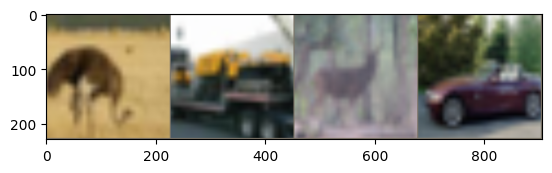

/opt/miniconda3/envs/pytorch_env_1/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/pytorch_env_1/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



ResNet18 Transfer Model Structure:
ResNetTransferModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, 

In [3]:
# 迁移学习部分
# 可视化函数 (需要更新以适应 ImageNet 的标准化)
def imshow_transfer_learning(img):
    # ImageNet 的均值和标准差 (用于反标准化)
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0)) # 将(C, H, W)变为(H, W, C)
    img = imagenet_std * img + imagenet_mean # 反标准化
    img = np.clip(img, 0, 1) # 将像素值裁剪到[0,1]
    plt.imshow(img)
    plt.show()

print("\n--- 迁移学习模型训练 ---")
# 1. 数据加载 (使用新的数据加载函数)
batch_size = 64
data_root = '../data' # 数据集将下载到项目根目录下的 data 文件夹
transfer_train_loader, transfer_test_loader, transfer_classes = \
    get_cifar10_dataloaders_for_transfer_learning(batch_size=batch_size, data_root=data_root)

print(f"\nTransfer Learning Training data loaded: {len(transfer_train_loader.dataset)} samples, {len(transfer_train_loader)} batches.")
print(f"Transfer Learning Test data loaded: {len(transfer_test_loader.dataset)} samples, {len(transfer_test_loader)} batches.")
print(f"Number of classes: {len(transfer_classes)}")

# 获取一个随机批次并显示 (确认图像尺寸已变大)
dataiter_tl = iter(transfer_train_loader)
images_tl, labels_tl = next(dataiter_tl)
print(f"Image batch shape after resize for Transfer Learning: {images_tl.shape}") # 应该看到 (64, 3, 224, 224)
print(' '.join(f'{transfer_classes[labels_tl[j]]:5s}' for j in range(4)))
imshow_transfer_learning(torchvision.utils.make_grid(images_tl[:4]))


# 2. 模型实例化 (使用 ResNetTransferModel)
# num_classes 应该与 CIFAR-10 的类别数匹配
transfer_model = ResNetTransferModel(num_classes=len(transfer_classes), freeze_features=False) # 不冻结特征层，进行微调
transfer_model = transfer_model.to(device)

print("\nResNet18 Transfer Model Structure:")
print(transfer_model) # 打印整个模型结构，会比较长


# 3. 损失函数和优化器
criterion_tl = nn.CrossEntropyLoss()

# 迁移学习通常使用较小的学习率
initial_learning_rate_tl = 0.0001 # 比 0.001 小一个数量级
optimizer_tl = optim.Adam(transfer_model.parameters(), lr=initial_learning_rate_tl, weight_decay=1e-5) # 保持最佳的 weight_decay

# 学习率调度器 (StepLR)
# 迁移学习收敛较快，调度器步长和幅度可能需要调整
step_size_tl = 10 # 每10个Epoch衰减
gamma_tl = 0.5 # 衰减到0.5，比0.7衰减快一点，因为初始学习率更小了
scheduler_tl = optim.lr_scheduler.StepLR(optimizer_tl, step_size=step_size_tl, gamma=gamma_tl)

# 4. 训练循环
num_epochs_tl = 20 # 迁移学习通常不需要很多 Epoch 就能达到好效果，先从 20 开始尝试

train_model(transfer_model, transfer_train_loader, criterion_tl, optimizer_tl, num_epochs_tl, device, scheduler_tl)

# 5. 评估循环
final_accuracy_tl = evaluate_model(transfer_model, transfer_test_loader, device, transfer_classes)

# 6. 模型保存与加载
PATH_RESNET_TRANSFER = '../cifar10_resnet18_transfer.pth' 
save_model(transfer_model, PATH_RESNET_TRANSFER)

# 加载模型：需要先实例化模型类，然后加载 state_dict
# 这里需要重新构建 ResNetTransferModel 实例，确保结构匹配
loaded_transfer_model = ResNetTransferModel(num_classes=len(transfer_classes), freeze_features=False)
loaded_transfer_model = load_model(lambda: loaded_transfer_model, PATH_RESNET_TRANSFER, device) # 这里的lambda包装是为了匹配load_model的期望

print(f"Accuracy of loaded ResNet18 Transfer model on test images: {evaluate_model(loaded_transfer_model, transfer_test_loader, device, transfer_classes):.2f}%")